# Posthoc Classifier

## Install, Paths and Parameters

In [93]:
# This extension reloads external Python files
import os
from pathlib import Path
import getpass
import numpy as np
import pandas as pd
import time
import math
import torch
from torch import nn
from tqdm import tqdm
import random
import sys
from torch.utils.data import random_split
from matplotlib import pyplot as plt


# allow imports when running script from within project dir
[sys.path.append(i) for i in ['.', '..']]

# local
from src.helpers.helpers import get_random_indexes, get_random_classes
from src.model.dino_model import get_dino
from src.model.data import create_loader, adv_dataset
from src.model.eval import validate_network

# seed
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

username = getpass.getuser()
DATA_PATH = Path('/','cluster', 'scratch', 'thobauma', 'dl_data')

ORI_PATH = Path(DATA_PATH, 'ori_data/validation/')
ORI_LABEL_PATH = Path(ORI_PATH,'correct_labels.txt')
ORI_IMAGES_PATH = Path(ORI_PATH,'images')

DN_PATH = Path(DATA_PATH, 'damageNet')
DN_LABEL_PATH = Path(DN_PATH, 'val_damagenet.txt')
DN_IMAGES_PATH = Path(DN_PATH, 'images')

PGD_PATH = Path(DATA_PATH, 'adversarial_data/pgd_03/validation')
PGD_LABEL_PATH = ORI_LABEL_PATH
PGD_IMAGES_PATH = Path(PGD_PATH, 'images')

POSTHOC_PATH = Path(DATA_PATH, 'posthoc/')

DN_POSTHOC_PATH = Path(POSTHOC_PATH, 'damagenet')
DN_POSTHOC_LABEL_PATH = Path(DN_POSTHOC_PATH, 'labels.csv')

PGD_POSTHOC_PATH = Path(POSTHOC_PATH, 'pgd')
PGD_POSTHOC_LABEL_PATH = Path(PGD_POSTHOC_PATH, 'labels.csv')

In [34]:
# If CLASS_SUBSET is specified, INDEX_SUBSET will be ignored. Set CLASS_SUBSET=None if you want to use indexes.
INDEX_SUBSET = get_random_indexes()
CLASS_SUBSET = get_random_classes()
INDEX_SUBSET = None
CLASS_SUBSET = None

BATCH_SIZE = 1

DEVICE = 'cuda'

In [35]:
#!python $HOME/deeplearning/setup/collect_env.py

## Import DINO
Official repo: https://github.com/facebookresearch/dino

In [36]:
model, linear_classifier = get_dino()

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Model vit_small built.
We load the reference pretrained linear weights.


## Load data

In [37]:
ori_loader = create_loader(ORI_IMAGES_PATH, ORI_LABEL_PATH, INDEX_SUBSET, CLASS_SUBSET, BATCH_SIZE)

In [38]:
dn_loader = create_loader(DN_IMAGES_PATH, DN_LABEL_PATH, INDEX_SUBSET, CLASS_SUBSET, BATCH_SIZE)

In [39]:
pgd_loader = create_loader(PGD_IMAGES_PATH, PGD_LABEL_PATH, INDEX_SUBSET, CLASS_SUBSET, BATCH_SIZE)

## Adversarial Sample Tuples

### Iterator

In [40]:
# Performs a forward pass given a sample `inp` and a classifier.
def generate_model_output(inp, n=4):
    inp = inp.to("cuda")
    # add one dimension to input image (get_intermediate_layers expects it)
    inp = inp.unsqueeze(dim=0)
    intermediate_output = model.get_intermediate_layers(inp, n)
    return torch.cat([x[:, 0] for x in intermediate_output], dim=-1)

In [134]:
class AdvTupleIterator:
    def __init__(self, ori_loader, dn_loader, model, linear_classifier, max=0, visualize=False):
        self.samples = adv_dataset(ori_loader, dn_loader, model, linear_classifier)
        self.max = max
        self.num = 0
        self.visualize = visualize
    
    def __iter__(self):
        self.num = 0
        return self
        
    def __next__(self):
        if(self.max > 0 and self.num >= self.max):
            raise StopIteration
        self.num += 1
        # payload can be original or adversarial.
        sample, payload, label = next(self.samples)
        if self.visualize:
            img = payload.permute(1, 2, 0)
            plt.imshow(img.cpu(), interpolation='nearest')
            plt.show()
        payload_out = generate_model_output(payload)
        if self.visualize:
            print("shape of image: {img.shape}")
            print(f"shape of model output: {payload_out.shape}")
        return sample, payload_out, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


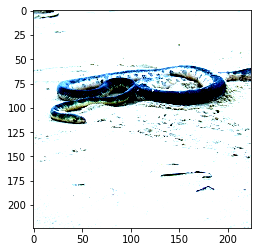

shape of image: {img.shape}
shape of model output: torch.Size([1, 1536])
payload 1/2 (label 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


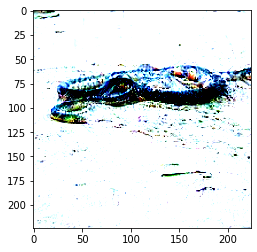

shape of image: {img.shape}
shape of model output: torch.Size([1, 1536])
payload 2/2 (label 1)

In [135]:
# testing iterator

total=2
samples = AdvTupleIterator(ori_loader, dn_loader, model, linear_classifier, visualize=True)
#samples = AdvTupleIterator(ori_loader, pgd_loader, model, linear_classifier, max=50)

for i in range(total):
  num, payload, label = next(samples)
  sys.stdout.write(f"\rpayload {i+1}/{total} (label {label})")
  sys.stdout.flush()

### Saving to disk (once)

In [143]:
# save to disk!
iterator = AdvTupleIterator(ori_loader, dn_loader, model, linear_classifier, max=0)
names = []
paths = []
labels = []
limit = 1000
for i, (name, payload, label) in enumerate(iterator):
    if limit > 0 and i >= limit: break
    sys.stdout.write(f"\r {i+1}/{limit} {name} (label {label})")
    sys.stdout.flush()
    # original: 0, adversarial: 1
    if label == 0:
        path = f"org/{name}"
    else:
        path = f"adv/{name}"
    paths.append(path)
    names.append(name)
    labels.append(label)
    path = Path(DN_POSTHOC_PATH, path)
    torch.save(payload, path)
    
df = pd.DataFrame(data={"path": paths, "name": names, "label": labels})
df.to_csv(DN_POSTHOC_LABEL_PATH, index=False)

 3138/0 ILSVRC2012_val_00002970 (label 1)

KeyboardInterrupt: 

### Load from disk (PyTorch dataset)

In [137]:
class AdvDataset(torch.utils.data.Dataset):
    def __init__(self, img_folder, index_df):
        super().__init__()
        self.img_folder = img_folder
        self.index_df = index_df
    
    def __len__(self):
        return len(self.index_df)
    
    def __getitem__(self, index):
        filename = self.index_df['path'].iloc[index]
        label = self.index_df['label'].iloc[index]
        payload = torch.load(Path(self.img_folder, filename))
        return filename, payload, label

## Posthoc Classifier

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [139]:
# Simple Binary Classifier Network
class SimpleBC(nn.Module):
    def __init__(self, input_shape):
        super(SimpleBC,self).__init__()
        self.fc1 = nn.Linear(input_shape,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [140]:
index_df = pd.read_csv(DN_POSTHOC_LABEL_PATH)
train_len = math.floor(len(index_df) * 0.7)
test_len = len(index_df) - train_len

train_dataset, test_dataset = random_split(AdvDataset(DN_POSTHOC_PATH, index_df), [train_len, test_len], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

In [141]:
len(index_df)

2000

In [142]:
from tqdm import tqdm

# Hyperparameters
EPOCHS = 10

# Initialise network
net = SimpleBC(1536)

# Select device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net.to(device)

# Set model to train
net.train()

# define loss, optimizer, and scheduler
criterion = nn.BCELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.Adagrad(net.parameters(), lr=0.01, lr_decay=1e-08, weight_decay=0)
# scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

losses = []
accur = []

train_files = []
test_files = []

# Train network
pbar = tqdm(range(EPOCHS))
for epoch in pbar:  # loop over the dataset multiple times

    # Metrics
    train_running_loss = 0.0
    train_running_loss_mean = 0.0
    train_acc = 0.0
    train_acc_mean = 0.0
    test_running_loss = 0.0
    test_acc = 0.0

    for i, (filename, inputs, labels) in enumerate(train_loader, start=0):        
        train_files.append(filename)
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        # Forward Pass
        outputs = net(inputs).float()
        outputs = outputs.reshape(-1)

        # Backpropagation
        optimizer.zero_grad() # Reset the gradient
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # loss train
        train_running_loss += loss.item()
        train_running_loss_mean = train_running_loss / (i+1)

        # accuracy train
        predicted = net(inputs).reshape(-1).detach().cpu().numpy().round()
        acc_labels = labels
        acc_labels = acc_labels.detach().cpu().numpy()
        inter = np.equal(predicted, acc_labels)
        train_acc += inter.sum()
        #train_acc_mean = train_acc / (i+1)
    
    with torch.set_grad_enabled(False):
        for filename, inputs, labels in test_loader:
            test_files.append(filename)
            try:
                # get the inputs; data is a list of [inputs, labels] and write to device
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                # Forward Pass
                outputs = net(inputs).float()
                outputs = outputs.reshape(-1)

                # loss test
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()

                # accuracy test
                outputs = outputs.detach().cpu().numpy().round()
                comparison = np.equal(labels.detach().cpu().numpy(), outputs)
                test_acc += comparison.sum()

            except Exception as e:
                print("Error: {}".format(e))
                pass

    losses.append(train_running_loss_mean)
    accur.append(train_acc_mean)
    pbar.set_description("Ep: {}\t Tr. Loss: {:.4f}\t Tr. Acc: {:.4f}\t T. Loss: {:.4f}\t T. Acc: {:.4f}".format(epoch, 
                                                                            train_running_loss_mean, 
                                                                            train_acc / len(train_loader.dataset), 
                                                                            test_running_loss, 
                                                                            test_acc / len(test_loader.dataset)))

print('Finished Training')

Ep: 9	 Tr. Loss: 0.0001	 Tr. Acc: 1.0000	 T. Loss: 0.3768	 T. Acc: 0.9983: 100%|██████████| 10/10 [00:26<00:00,  2.61s/it]

Finished Training


In [49]:
train_flat = []
for item in train_files:
    train_flat += list(item)

test_flat = []
for item in test_files:
    test_flat += list(item)

In [50]:
set(train_flat).intersection(set(test_flat))

set()